In [1]:
# Step 0. Load libraries and custom modules
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install wordcloud
!pip install sklearn
# Dataframes and matrices ----------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
plt.style.use('tableau-colorblind10')
# Mathematical functions -----------------------------------------------
from scipy.stats import norm
# Text processors ------------------------------------------------------
import unicodedata
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
# Preprocessing --------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Text modeling --------------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Model creating -------------------------------------------------------
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
# Metrics --------------------------------------------------------------
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
# Custom functions -----------------------------------------------------
from text_preprocessing import clean_stopwords 


[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# We'll use a collection of sentiments for text analysis as a dataset
# This dataset was published in Saif M. Mohammad and Peter Turney. (2013), 
# ``Crowdsourcing a Word-Emotion Association Lexicon.'' 
# Computational Intelligence, 29(3): 436-465.
# It's only for research and educational purposes.
# URL: http://saifmohammad.com/WebPages/lexicons.html  
nrc = pd.read_csv('../data/raw/NRC.csv', names=['word','sentiment','polarity'])
nrc = nrc.query('polarity == 1')

In [7]:
nrc

,word,sentiment,polarity
19,abacus,trust,1
23,abandon,fear,1
25,abandon,negative,1
27,abandon,sadness,1
30,abandoned,anger,1
...,...,...,...
141461,zest,anticipation,1
141464,zest,joy,1
141466,zest,positive,1
141469,zest,trust,1


In [5]:
# Step 1. Load the data
# Data extracted from https://www.thetrumparchive.com
# Data case: During the 2016 US presidential election, the candidate 
# Donald Trump used twitter to communicate with potential voters. 
# The campaign was during 2015-06-17 and 2016-11-08
# We'll try to analyze these campaign tweets from iPhone and Android
# Data description
# source -> device of origin
# id_str -> unique identifier
# text -> tweet text content
# created_at -> Date of creation, not including timezone
# retweet_count -> Count of retweets (difusion)
# in_reply_to_usr_id_str -> If it's a reply, grab the user id
# favourite_count -> Count of users that liked the tweet
# is_retweet -> If the post is a retweet  
# 1.1 Open data and get a glimpse
df_raw = pd.read_csv('../data/raw/trump_tweets.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20761 entries, 0 to 20760
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   source                   20761 non-null  object 
 1   id_str                   20761 non-null  int64  
 2   text                     20761 non-null  object 
 3   created_at               20761 non-null  object 
 4   retweet_count            20761 non-null  int64  
 5   in_reply_to_user_id_str  2442 non-null   float64
 6   favorite_count           20761 non-null  int64  
 7   is_retweet               20761 non-null  bool   
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 1.1+ MB


In [6]:
# 1.1 Sample some observations
df_raw.sample(10)

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
9711,Twitter Web Client,286886047776903168,The boardroom has never been as intense as in ...,2013-01-03T17:25:38Z,48,NaN,35,False
16897,Twitter for iPhone,739826625546752000,Remembering the fallen heroes on #DDay - June ...,2016-06-06T14:29:47Z,15005,NaN,36944,False
5363,Twitter for Android,374856482535538688,"President Obama's ""Arab Spring"" is not looking...",2013-09-03T11:28:44Z,104,NaN,46,False
6335,Twitter Web Client,349181679392407555,@TrumpPhillyGM @DavisCPAGroup @TrumpPhillyPro ...,2013-06-24T15:06:14Z,0,402765717.0,0,False
3783,Twitter Web Client,179617014023852034,He @RickSantorum should get out of the race so...,2012-03-13T17:16:47Z,131,NaN,5,False
13414,Twitter for Android,630670147938861056,I will be interviewed on @TODAY Show at 7:00 A...,2015-08-10T09:20:55Z,464,NaN,1734,False
3494,Twitter Web Client,199314889532112896,I’m not sure about @teresa_giudice as Project ...,2012-05-07T01:49:07Z,18,NaN,2,False
8701,Twitter Web Client,301771083894382592,@steffanpiper Very good!,2013-02-13T19:13:27Z,1,24725337.0,1,False
6332,Twitter Web Client,349192067777437696,Even liberals &amp; Democrats think Eric Schne...,2013-06-24T15:47:31Z,25,NaN,14,False
13343,Twitter for Android,635214634627256320,"Jeb Bush is weak on illegal immigration, in fa...",2015-08-22T22:19:05Z,2718,NaN,5795,False


In [8]:
# Step 2. Transform and wrangle the data
# 2.1 Make a copy
df_interim = df_raw.copy()

In [9]:
# 2.2 Get rid of uninformative columns
df_interim = df_interim.drop(['id_str','is_retweet','in_reply_to_user_id_str'], axis=1)

In [10]:
# 2.3 Convert columns to the right format
df_interim['created_at'] = df_interim['created_at'].astype('datetime64')
df_interim['source'] = pd.Categorical(df_interim['source'])

In [11]:
# 2.4 Filter dates for analysis
df_interim = df_interim.loc[(df_interim['created_at'] >= '2015-06-17') \
    & (df_interim['created_at'] <= '2016-11-08')]

In [13]:
# 2.5 Consider time is UTC, convert to EST
df_interim["created_at"] += pd.Timedelta(-5, unit="h")


In [14]:
# 2.5 Filter source for analysis
df_interim = df_interim.loc[(df_interim['source'].str.contains('iPhone')) \
    | (df_interim['source'].str.contains('Android'))]
df_interim['source'] = df_interim['source'].cat.remove_unused_categories()

In [15]:
# 2.5 Save and create a copy for analysis
df_interim.to_csv('../data/interim/trump_tweets.csv', index=False)
df = df_interim.copy()

In [16]:
# Step 3. Perform EDA
# 3.1 Get basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3946 entries, 12072 to 18506
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   source          3946 non-null   category      
 1   text            3946 non-null   object        
 2   created_at      3946 non-null   datetime64[ns]
 3   retweet_count   3946 non-null   int64         
 4   favorite_count  3946 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(2), object(1)
memory usage: 158.0+ KB


In [17]:
# 3.2 Get a sample
df.sample(10)

,source,text,created_at,retweet_count,favorite_count
15428,Twitter for Android,REPEAL AND REPLACE OBAMACARE!,2016-10-26 06:02:53,19861,54161
17670,Twitter for iPhone,Phony Club For Growth tried to shake me down f...,2016-03-09 16:46:12,4856,13859
16103,Twitter for iPhone,Dwyane Wade's cousin was just shot and killed ...,2016-08-27 11:26:08,9197,27299
12553,Twitter for Android,Just got back from South Carolina. Going to Al...,2015-11-20 17:51:24,957,3118
15624,Twitter for iPhone,I will sign the first bill to repeal #Obamacar...,2016-10-17 17:02:11,14655,38826
18431,Twitter for iPhone,(2/2) David brilliantly tells it like it is --...,2016-01-09 12:56:10,1023,2853
12735,Twitter for Android,.@Morning_Joe: Marco only won the debate in th...,2015-11-02 07:24:05,824,1755
16298,Twitter for iPhone,Hillary Clinton has bad judgment and is unfit ...,2016-08-05 08:08:35,9080,26050
17537,Twitter for Android,Will be interviewed on @ThisWeekABC this morni...,2016-03-20 06:55:27,2171,9103
12261,Twitter for iPhone,.@scottienhughes - you were fantastic on CNN. ...,2015-12-14 17:25:35,833,2530


In [18]:
# 3.3 Describe numerical and datetime data
df.describe(datetime_is_numeric=True)

,created_at,retweet_count,favorite_count
count,3946,3946.000000,3946.000000
mean,2016-03-31 07:49:53.323872256,5839.465281,15666.982767
min,2015-06-19 20:03:05,61.000000,167.000000
25%,2015-12-20 18:19:10.500000,2013.250000,5350.000000
50%,2016-03-16 05:29:30.500000,4162.500000,11981.500000
75%,2016-07-25 09:04:26.500000,7807.250000,21527.000000
max,2016-11-07 17:21:53,168765.000000,297281.000000
std,NaN,6156.818896,14650.408743


In [19]:
# 3.4 Describe categorical data
df['source'].value_counts()

Twitter for iPhone     2099
Twitter for Android    1847
Name: source, dtype: int64

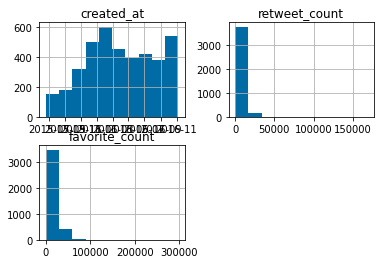

In [20]:
# 3.5 Get histograms for numerical data
df.hist()
plt.show()

In [21]:
# 3.6 Make a plot of tweets frequence rate by source
df_plot = (df
            .assign(hour=df["created_at"].dt.hour)
            .groupby(["source", "hour"])
            .agg(count=("source", "count"))
            .assign(rate=lambda df: df["count"]/df.groupby("source")["count"].sum())
            .reset_index())
df_plot

,source,hour,count,rate
0,Twitter for Android,0,22,0.011911
1,Twitter for Android,1,2,0.001083
2,Twitter for Android,2,6,0.003249
3,Twitter for Android,3,1,0.000541
4,Twitter for Android,4,28,0.015160
5,Twitter for Android,5,98,0.053059
6,Twitter for Android,6,159,0.086086
7,Twitter for Android,7,194,0.105035
8,Twitter for Android,8,210,0.113698
9,Twitter for Android,9,132,0.071467


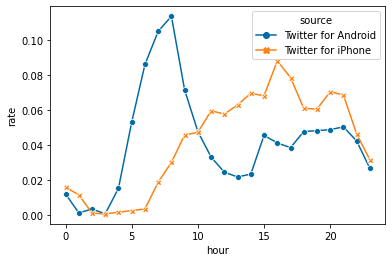

In [22]:
sns.lineplot(data=df_plot, x="hour", y="rate", hue="source", markers=True, style="source", dashes=False)
plt.show()

In [23]:
# 3.7 Get a glimpse of the most retweeted tweets
df.sort_values(by="retweet_count", ascending=False)[["text", "retweet_count"]][:10]

,text,retweet_count
16875,How long did it take your staff of 823 people ...,168765
17183,Happy #CincoDeMayo! The best taco bowls are ma...,85465
15333,MAKE AMERICA GREAT AGAIN!,59098
15758,Here is my statement. https://t.co/WAZiGoQqMQ,51891
16548,Such a great honor to be the Republican Nomine...,41616
15340,If Obama worked as hard on straightening out o...,41479
15827,For those few people knocking me for tweeting ...,40850
15756,The media and establishment want me out of the...,40772
16583,I am pleased to announce that I have chosen Go...,38782
16848,Is President Obama going to finally mention th...,38456


In [24]:
# 3.8 Get a glimpse of the most liked tweets
df.sort_values(by="favorite_count", ascending=False)[["text", "favorite_count"]][:10]

,text,favorite_count
16875,How long did it take your staff of 823 people ...,297281
16548,Such a great honor to be the Republican Nomine...,129652
15758,Here is my statement. https://t.co/WAZiGoQqMQ,120244
15781,Mike Pence won big. We should all be proud of ...,120189
17183,Happy #CincoDeMayo! The best taco bowls are ma...,119759
15333,MAKE AMERICA GREAT AGAIN!,115387
15827,For those few people knocking me for tweeting ...,107497
15756,The media and establishment want me out of the...,105680
15340,If Obama worked as hard on straightening out o...,102045
16583,I am pleased to announce that I have chosen Go...,92250


In [25]:
# 3.9 Let's get a glimpse of common words in the tweets' text
df["text"].str.split(expand=True).stack().value_counts()[:10]

the    1965
to     1369
and    1186
I      1133
in     1098
a       987
of      957
is      904
on      829
for     703
dtype: int64

In [27]:
# 3.10 Process text to extract stopwords
df["text_clean"] = df.text.str.lower()
stop_dict = stopwords.words("english")
df["text_clean"] = df["text_clean"].apply(lambda x: clean_stopwords(x, stop_dict=stop_dict))
df.text_clean = df.text_clean.str.replace(r'''['!,.]''','', regex=True)

In [28]:
# 3.11 Extract urls
url_pat = 'https://t.co/[A-Za-z\d]+|&amp;'
df.text_clean = df.text_clean.str.replace(url_pat, "", regex=True)


In [29]:
# 3.12 Extract special characters
df.text_clean = df.text_clean.str.replace(r'''[!.,():\-%$/'"']''', "", regex=True)

In [30]:
# 3.13 Extract numbers
df.text_clean = df.text_clean.str.replace(r'[\d]+', "", regex=True)

In [31]:
# 3.14 See the results
df[["text" ,"text_clean"]].sample(10)

,text,text_clean
15450,'Democratic operative caught on camera: Hillar...,democratic operative caught camera hillary per...
13116,".@oreillyfactor, why don't you have some knowl...",@oreillyfactor knowledgeable talking heads sho...
16776,Hillary Lies to Benghazi Families\n#CrookedHil...,hillary lies benghazi families #crookedhillary...
15671,"Thank you for your support Greensboro, North C...",thank support greensboro north carolina next s...
17608,Can't watch Crazy Megyn anymore. Talks about m...,cant watch crazy megyn anymore talks never me...
17230,Thank you Indiana! #Trump2016 https://t.co/WAu...,thank indiana #trump httpstcowauinrnzx
16322,Thank you Virginia! #ImWithYou https://t.co/9i...,thank virginia #imwithyou httpstcoinchbvwm
16075,Great trip to Mexico today - wonderful leader...,great trip mexico today wonderful leadership ...
16399,Crooked Hillary Clinton made up facts about me...,crooked hillary clinton made facts me forgot m...
16395,Crooked Hillary Clinton mentioned me 22 times ...,crooked hillary clinton mentioned times long ...


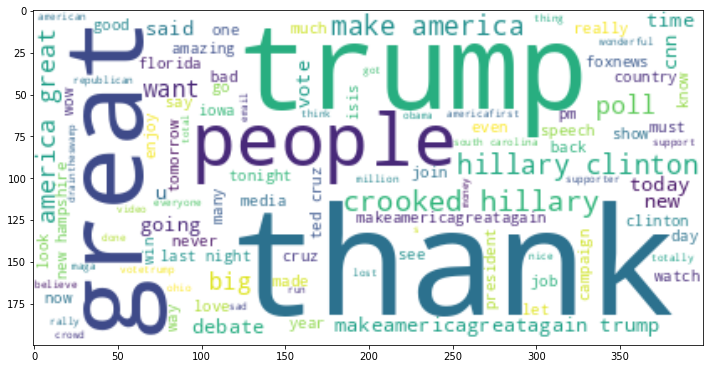

In [41]:
# 3.15 Let's see a wordcloud
text = " ".join(i for i in df.text_clean)
wordcloud = WordCloud(max_words=100, background_color="White").generate(text)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

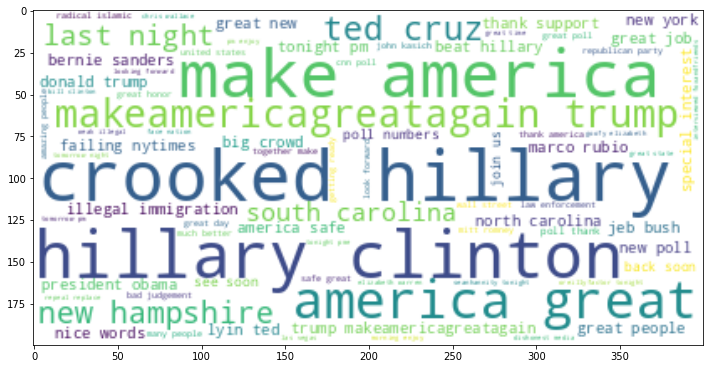

In [42]:
#Dos palabras que se repiten en conjunto - Bigramo 
wordcloud_bg = WordCloud(collocation_threshold=2, collocations=True, max_words=100, background_color="White").generate(text)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud_bg, interpolation="bilinear")
plt.show()

In [45]:
# asociar cada palabra a un sentrimiento
df_word_split=(df
                .drop(['text','created_at','retweet_count','favorite_count'],axis=1)
                .assign(text=df['text_clean'].str.split())).explode('text').drop('text_clean',axis=1).rename(columns={'text':'word'})
df_word_split

,source,word
12072,Twitter for Android,would
12072,Twitter for Android,like
12072,Twitter for Android,wish
12072,Twitter for Android,everyone
12072,Twitter for Android,happy
...,...,...
18506,Twitter for Android,together
18506,Twitter for Android,make
18506,Twitter for Android,america
18506,Twitter for Android,great


In [46]:
#aplicamos un join
df_word_split.merge(nrc[["word", "sentiment"]], on="word", how="inner")

,source,word,sentiment
0,Twitter for Android,happy,anticipation
1,Twitter for Android,happy,joy
2,Twitter for Android,happy,positive
3,Twitter for Android,happy,trust
4,Twitter for iPhone,happy,anticipation
...,...,...,...
17547,Twitter for Android,stiff,negative
17548,Twitter for Android,embarrassment,fear
17549,Twitter for Android,embarrassment,negative
17550,Twitter for Android,embarrassment,sadness


In [47]:
df_sent = df_word_split.\
    merge(nrc[["word", "sentiment"]], on="word", how="inner").\
    groupby(["source", "sentiment"]).agg(count=("sentiment","count")).\
    reset_index().pivot_table(index=["sentiment"], columns=["source"], values="count").\
    reset_index().\
    rename(columns={"Twitter for Android":"Android","Twitter for iPhone":"iPhone"})

df_sent

source,sentiment,Android,iPhone
0,anger,949,514
1,anticipation,986,725
2,disgust,632,307
3,fear,815,477
4,joy,743,543
5,negative,1671,925
6,positive,1963,1522
7,sadness,911,512
8,surprise,587,385
9,trust,1363,1022


In [50]:
#odd ratios
df_odd_ratio = df_sent.\
    assign(odd_ratio=(df_sent["Android"]/(df_sent["Android"].sum()-df_sent["Android"]))/(df_sent["iPhone"]/(df_sent["iPhone"].sum()-df_sent["iPhone"])))

df_odd_ratio["log_or"] = np.log(df_odd_ratio["odd_ratio"])

In [51]:
df_odd_ratio.sort_values(by="log_or", ascending=False)

source,sentiment,Android,iPhone,odd_ratio,log_or
2,disgust,632,307,1.365482,0.311508
0,anger,949,514,1.225269,0.203160
5,negative,1671,925,1.212601,0.192767
7,sadness,911,512,1.176546,0.162583
3,fear,815,477,1.124833,0.117634
8,surprise,587,385,0.994922,-0.005091
4,joy,743,543,0.885109,-0.122044
1,anticipation,986,725,0.876222,-0.132136
9,trust,1363,1022,0.851456,-0.160808
6,positive,1963,1522,0.806001,-0.215670


In [52]:
# intervalo de confianza
# error standard para odd_ratio
df_odd_ratio["se"] = np.sqrt(1 / df_odd_ratio.Android + 1 / (df_odd_ratio.Android.sum() - df_odd_ratio.Android) + 1 / df_odd_ratio.iPhone + 1 / (df_odd_ratio.iPhone.sum() - df_odd_ratio.iPhone))
df_odd_ratio["conf_low"] = df_odd_ratio.log_or - norm.ppf(0.975) * df_odd_ratio.se
df_odd_ratio["conf_high"] = df_odd_ratio.log_or + norm.ppf(0.975) * df_odd_ratio.se
df_odd_ratio.sort_values(by="log_or", ascending=False)

source,sentiment,Android,iPhone,odd_ratio,log_or,se,conf_low,conf_high
2,disgust,632,307,1.365482,0.311508,0.071349,0.171666,0.451349
0,anger,949,514,1.225269,0.203160,0.057083,0.091280,0.315041
5,negative,1671,925,1.212601,0.192767,0.044246,0.106046,0.279489
7,sadness,911,512,1.176546,0.162583,0.057529,0.049828,0.275338
3,fear,815,477,1.124833,0.117634,0.059836,0.000358,0.234910
8,surprise,587,385,0.994922,-0.005091,0.067479,-0.137347,0.127165
4,joy,743,543,0.885109,-0.122044,0.058697,-0.237087,-0.007001
1,anticipation,986,725,0.876222,-0.132136,0.051560,-0.233192,-0.031081
9,trust,1363,1022,0.851456,-0.160808,0.044602,-0.248227,-0.073388
6,positive,1963,1522,0.806001,-0.215670,0.038299,-0.290735,-0.140606


In [ ]:
#comparamos log_or y vemos que este entre conf low / high

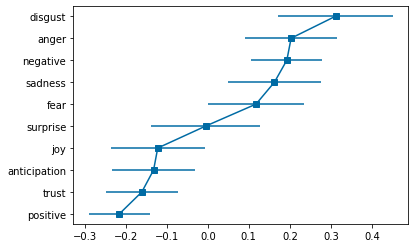

In [55]:
df_odd_ratio = df_odd_ratio.sort_values(by="log_or", ascending=True)
plt.errorbar(df_odd_ratio.log_or, df_odd_ratio.sentiment, marker="s", xerr=((df_odd_ratio.log_or - df_odd_ratio.conf_low), (df_odd_ratio.conf_high - df_odd_ratio.log_or)))
plt.show()